In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



In [ ]:
import pandas as pd

# Load the training dataset
train_df = pd.read_csv("train.csv")

# Display first few rows
print(train_df.head())

# Dataset structure
print(train_df.info())

# Check class balance
print(train_df['target'].value_counts())


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
target
0    4342
1    3271
Name: cou

In [ ]:
# Null values summary
print(train_df.isnull().sum())

# Optional: check percentage of missing data
print((train_df.isnull().sum() / len(train_df)) * 100)


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64


In [ ]:
# Fill missing keywords with "none"
train_df['keyword'].fillna("none", inplace=True)

# Fill missing locations with "unknown"
train_df['location'].fillna("unknown", inplace=True)


/tmp/ipython-input-4-2568912983.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['keyword'].fillna("none", inplace=True)
/tmp/ipython-input-4-2568912983.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

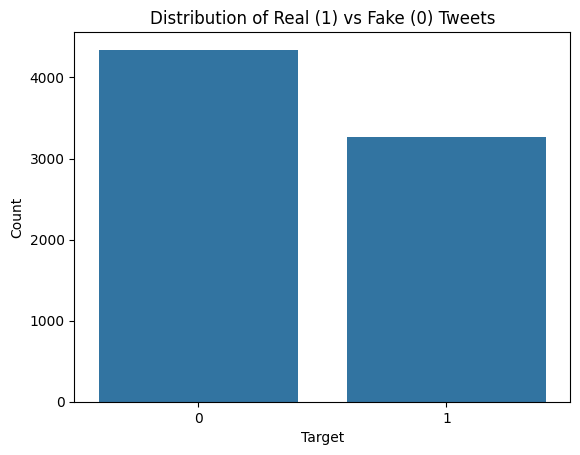

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='target', data=train_df)
plt.title("Distribution of Real (1) vs Fake (0) Tweets")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()


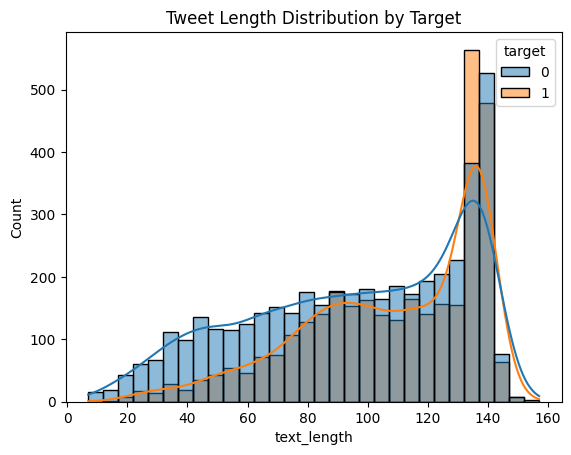

In [ ]:
train_df['text_length'] = train_df['text'].apply(len)

sns.histplot(data=train_df, x='text_length', hue='target', bins=30, kde=True)
plt.title("Tweet Length Distribution by Target")
plt.show()


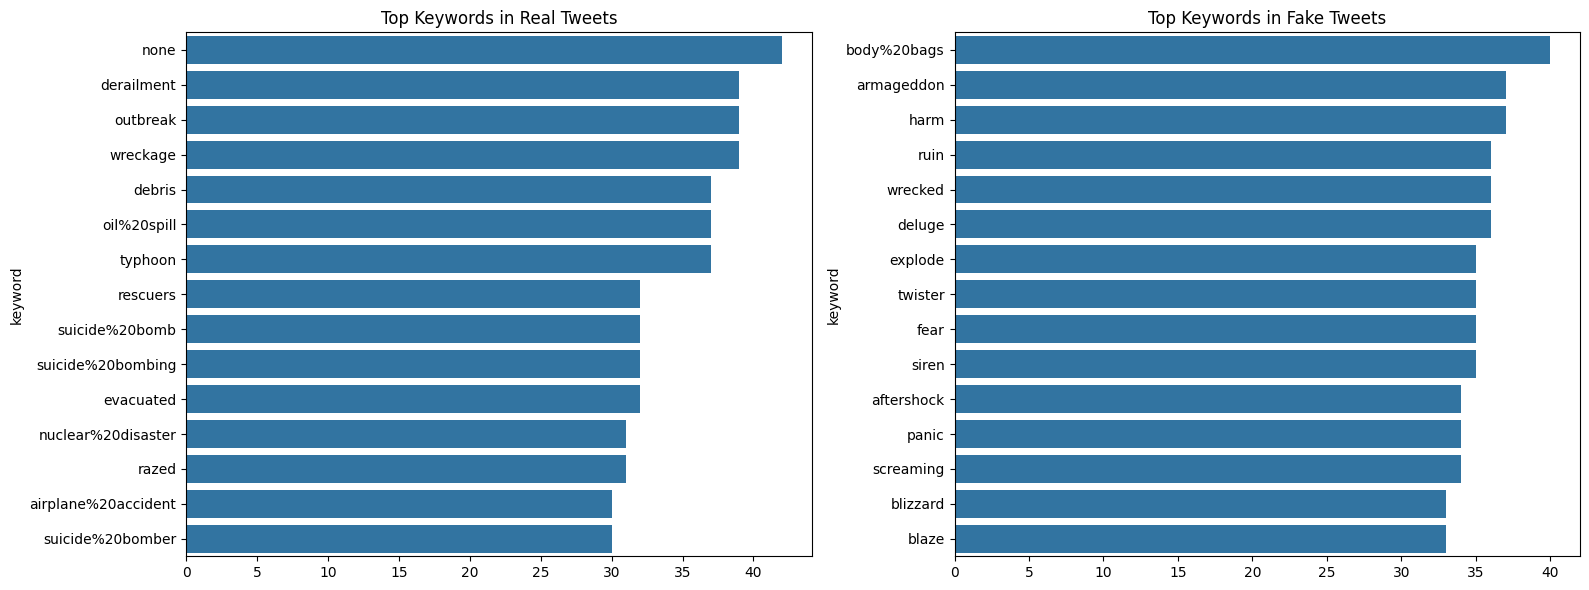

In [ ]:
# Top 15 keywords in real and fake tweets
real_keywords = train_df[train_df['target'] == 1]['keyword'].value_counts().head(15)
fake_keywords = train_df[train_df['target'] == 0]['keyword'].value_counts().head(15)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(x=real_keywords.values, y=real_keywords.index, ax=axs[0])
axs[0].set_title("Top Keywords in Real Tweets")

sns.barplot(x=fake_keywords.values, y=fake_keywords.index, ax=axs[1])
axs[1].set_title("Top Keywords in Fake Tweets")

plt.tight_layout()
plt.show()


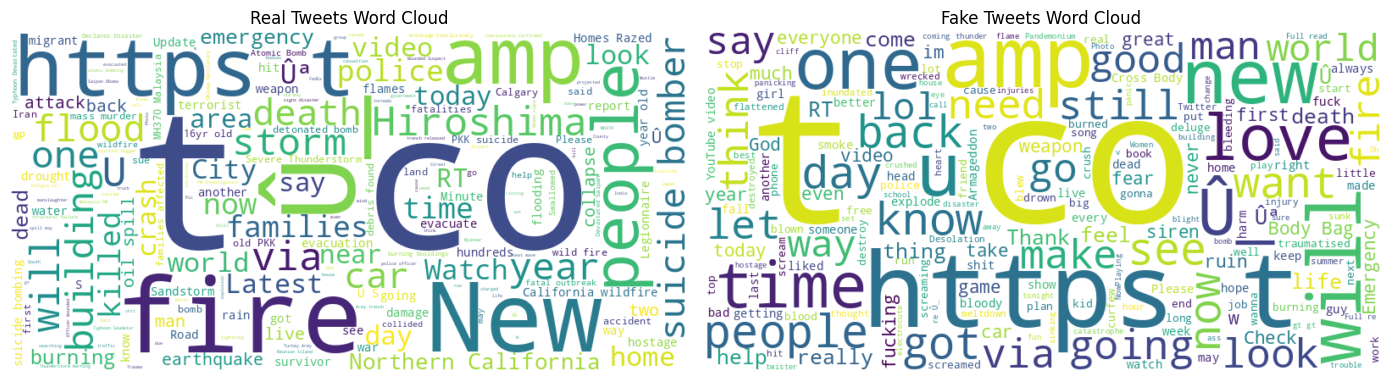

In [ ]:
from wordcloud import WordCloud

# Join all texts
real_words = " ".join(train_df[train_df['target'] == 1]['text'].astype(str))
fake_words = " ".join(train_df[train_df['target'] == 0]['text'].astype(str))

# Generate word clouds
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_words)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title("Real Tweets Word Cloud")
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_words)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title("Fake Tweets Word Cloud")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download required resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab') # Download punkt_tab resource

# Load spacy English model
nlp = spacy.load('en_core_web_sm')

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
def preprocess_text(text):
    # Remove punctuation, numbers, special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Lowercase
    text = text.lower()

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    filtered = [word for word in tokens if word not in stop_words]

    # Apply stemming
    stemmed = [stemmer.stem(word) for word in filtered]

    # Apply lemmatization using SpaCy
    doc = nlp(" ".join(stemmed))
    lemmatized = [token.lemma_ for token in doc]

    return " ".join(lemmatized)


# Apply preprocessing to the text column
train_df['clean_text'] = train_df['text'].apply(preprocess_text)



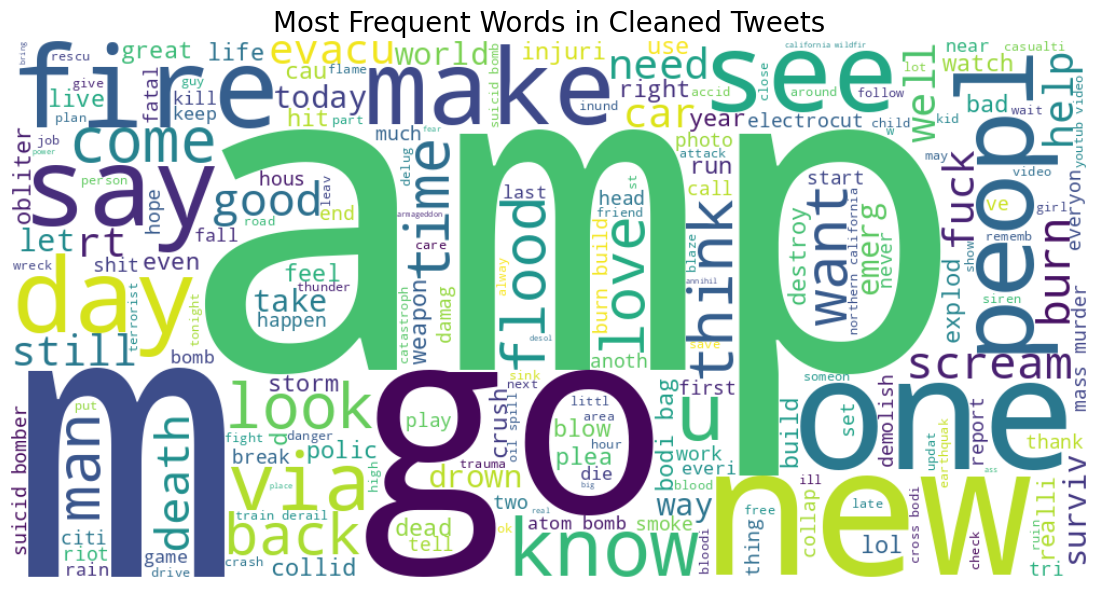

In [ ]:
# Join all cleaned text
all_words = " ".join(train_df['clean_text'])

# Generate and show wordcloud
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(all_words)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Most Frequent Words in Cleaned Tweets", fontsize=20)
plt.axis('off')
plt.show()


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize vectorizer
count_vec = CountVectorizer(max_features=5000)  # You can tune this

# Fit and transform
X_count = count_vec.fit_transform(train_df['clean_text'])

print("CountVectorizer shape:", X_count.shape)


CountVectorizer shape: (7613, 5000)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vec = TfidfVectorizer(max_features=5000)

# Fit and transform
X_tfidf = tfidf_vec.fit_transform(train_df['clean_text'])

print("TF-IDF shape:", X_tfidf.shape)


TF-IDF shape: (7613, 5000)


In [ ]:
y = train_df['target']


In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=64)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # CLS token

# Apply to a sample of tweets (BERT is slow)
X_bert = np.vstack(train_df['clean_text'].head(100).apply(get_bert_embedding))

print("BERT Embedding shape (sample):", X_bert.shape)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT Embedding shape (sample): (100, 768)


In [ ]:
X = X_tfidf  # or X_count, X_w2v, etc.
y = train_df['target']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)


In [ ]:
svm_model = SVC(kernel='linear')  # or 'rbf'
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)


In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)


In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



Logistic Regression Performance:
Accuracy: 0.7879185817465528
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       874
           1       0.80      0.67      0.73       649

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.78      1523



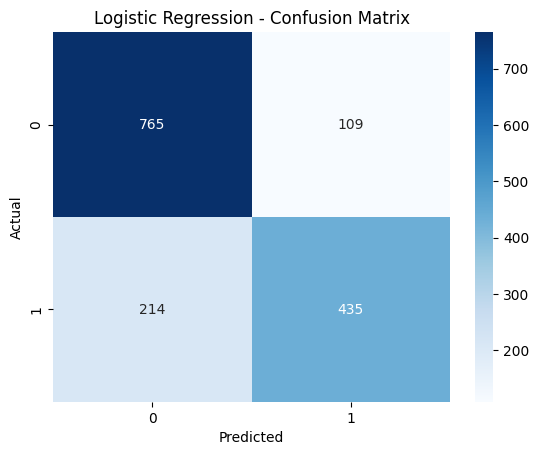


SVM Performance:
Accuracy: 0.7846355876559422
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       874
           1       0.78      0.69      0.73       649

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.78      1523
weighted avg       0.78      0.78      0.78      1523



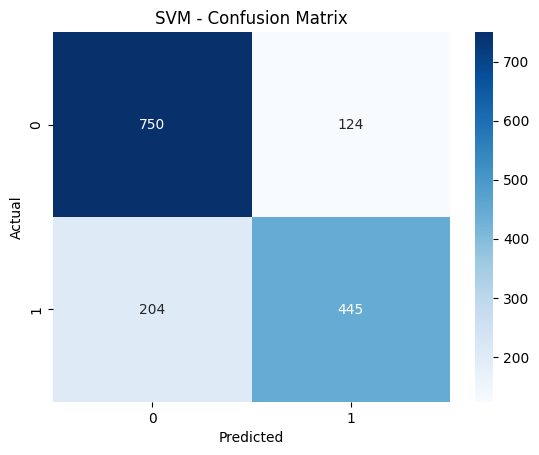


Naive Bayes Performance:
Accuracy: 0.7957977675640184
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       874
           1       0.81      0.68      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



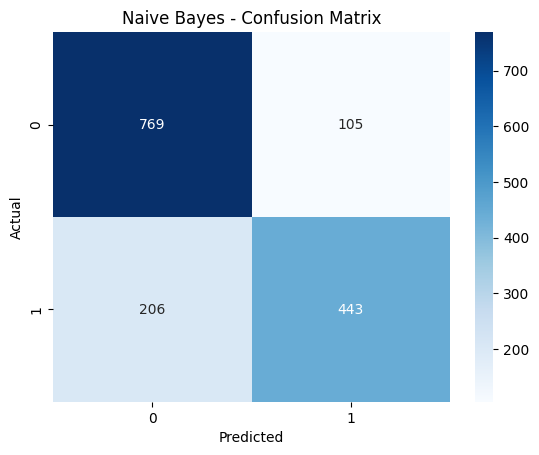

In [ ]:
evaluate_model(y_test, lr_preds, "Logistic Regression")
evaluate_model(y_test, svm_preds, "SVM")
evaluate_model(y_test, nb_preds, "Naive Bayes")


In [ ]:
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs']
}

lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=5, scoring='f1', n_jobs=-1)
lr_grid.fit(X_train, y_train)

print("Best Parameters (Logistic Regression):", lr_grid.best_params_)
lr_best_model = lr_grid.best_estimator_
lr_best_preds = lr_best_model.predict(X_test)


Best Parameters (Logistic Regression): {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='f1', n_jobs=-1)
svm_grid.fit(X_train, y_train)

print("Best Parameters (SVM):", svm_grid.best_params_)
svm_best_model = svm_grid.best_estimator_
svm_best_preds = svm_best_model.predict(X_test)


Best Parameters (SVM): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
nb_params = {
    'alpha': [0.01, 0.1, 1, 2, 5]
}

nb_grid = GridSearchCV(MultinomialNB(), nb_params, cv=5, scoring='f1', n_jobs=-1)
nb_grid.fit(X_train, y_train)

print("Best Parameters (Naive Bayes):", nb_grid.best_params_)
nb_best_model = nb_grid.best_estimator_
nb_best_preds = nb_best_model.predict(X_test)


Best Parameters (Naive Bayes): {'alpha': 0.1}



Logistic Regression (Tuned) Performance:
Accuracy: 0.7879185817465528
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       874
           1       0.80      0.67      0.73       649

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.78      1523



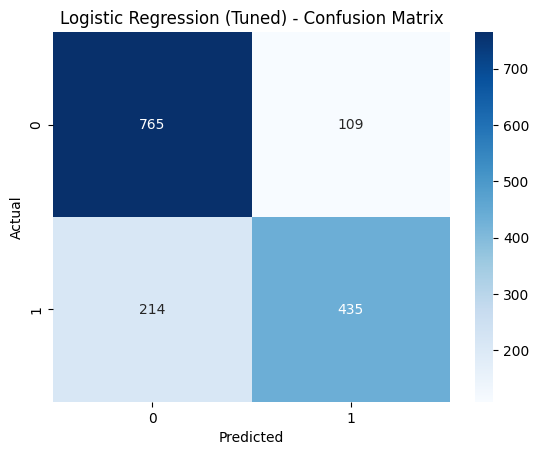


SVM (Tuned) Performance:
Accuracy: 0.7695338148391333
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       874
           1       0.76      0.67      0.71       649

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



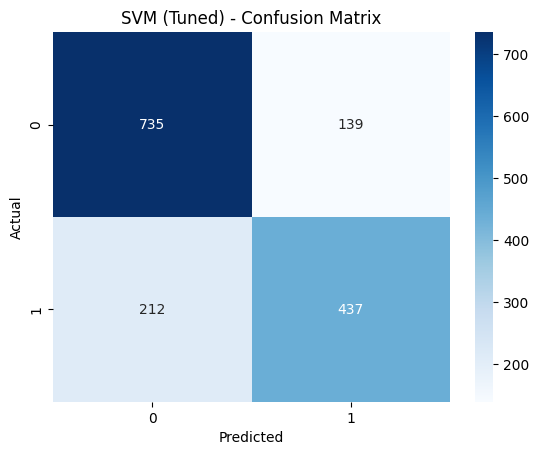


Naive Bayes (Tuned) Performance:
Accuracy: 0.7892317793827971
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       874
           1       0.78      0.71      0.74       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



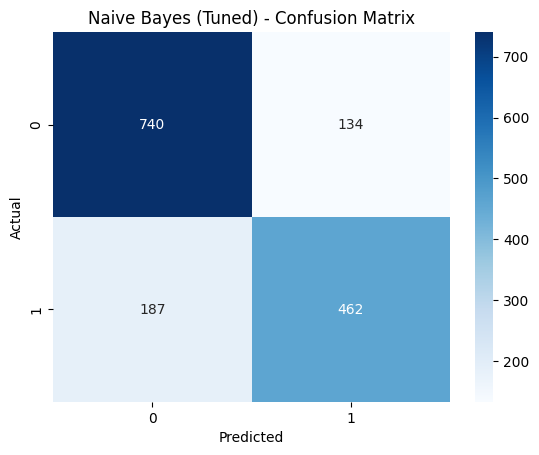

In [ ]:
evaluate_model(y_test, lr_best_preds, "Logistic Regression (Tuned)")
evaluate_model(y_test, svm_best_preds, "SVM (Tuned)")
evaluate_model(y_test, nb_best_preds, "Naive Bayes (Tuned)")


In [ ]:
models = {
    "Logistic Regression (Tuned)": lr_best_preds,
    "SVM (Tuned)": svm_best_preds,
    "Naive Bayes (Tuned)": nb_best_preds
}

for name, preds in models.items():
    acc = accuracy_score(y_test, preds)
    print(f"{name}: Accuracy = {acc:.4f}")


Logistic Regression (Tuned): Accuracy = 0.7879
SVM (Tuned): Accuracy = 0.7695
Naive Bayes (Tuned): Accuracy = 0.7892


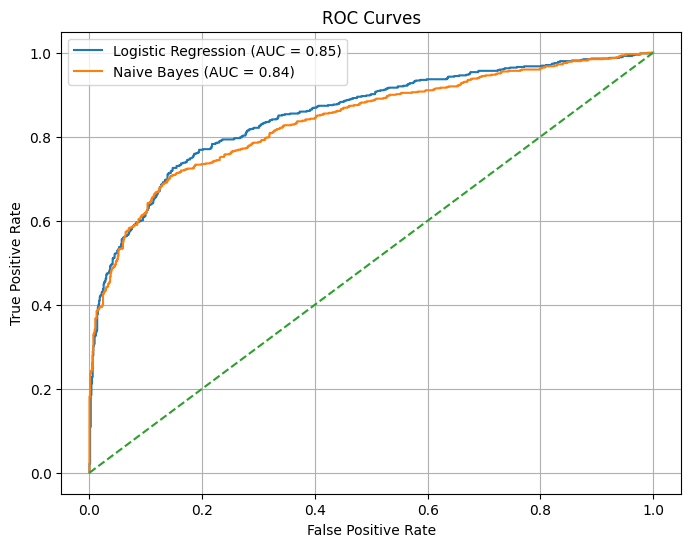

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X_test, y_test, label):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

plt.figure(figsize=(8, 6))

plot_roc_curve(lr_best_model, X_test, y_test, "Logistic Regression")
plot_roc_curve(nb_best_model, X_test, y_test, "Naive Bayes")

# SVM doesn’t support predict_proba by default, skip or use `probability=True` when training
# plot_roc_curve(svm_best_model, X_test, y_test, "SVM")

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()


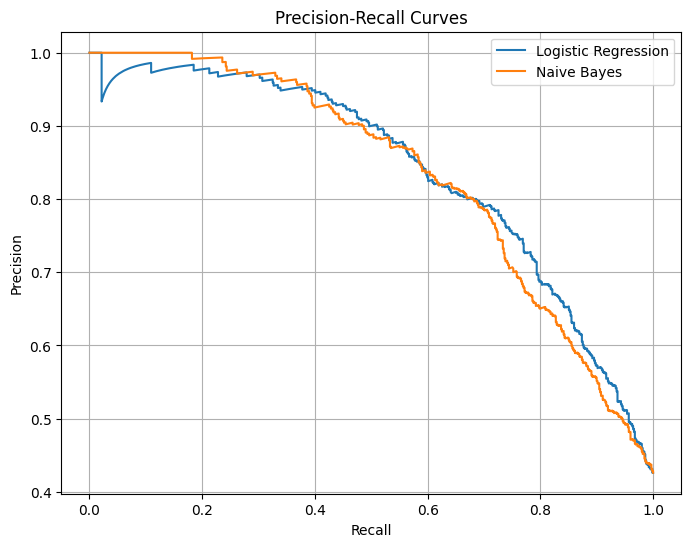

In [ ]:
from sklearn.metrics import precision_recall_curve

def plot_pr_curve(model, X_test, y_test, label):
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label=label)

plt.figure(figsize=(8, 6))

plot_pr_curve(lr_best_model, X_test, y_test, "Logistic Regression")
plot_pr_curve(nb_best_model, X_test, y_test, "Naive Bayes")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
plt.show()


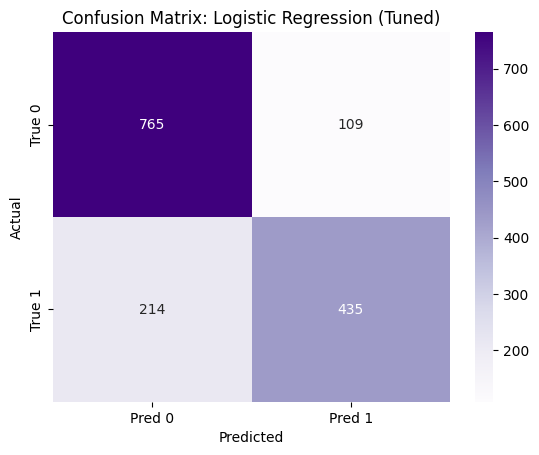

In [ ]:
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Example
plot_conf_matrix(y_test, lr_best_preds, "Logistic Regression (Tuned)")


In [ ]:
# Get misclassified indices
misclassified_idx = (y_test != lr_best_preds)

# Show 5 examples
misclassified_df = train_df.iloc[y_test[misclassified_idx].index]
misclassified_df['actual'] = y_test[misclassified_idx]
misclassified_df['predicted'] = lr_best_preds[misclassified_idx]

print(misclassified_df[['text', 'clean_text', 'actual', 'predicted']].head())


                                                   text  \
2644  So you have a new weapon that can cause un-ima...   
1765  my favorite lady came to our volunteer meeting...   
1817  @brianroemmele UX fail of EMV - people want to...   
4019  Who is bringing the tornadoes and floods. Who ...   
472   illegal alien released by Obama/DHS 4 times Ch...   

                                             clean_text  actual  predicted  
2644                  new weapon caus unimagin destruct       1          0  
1765  favorit ladi come volunt meet hope join youth ...       1          0  
1817  brianroemmel ux fail emv peopl want insert rem...       1          0  
4019  bring tornado flood bring climat chang god ame...       0          1  
472   illeg alien relea obamadh time charg rape amp ...       1          0  


/tmp/ipython-input-30-2453611773.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['actual'] = y_test[misclassified_idx]
/tmp/ipython-input-30-2453611773.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['predicted'] = lr_best_preds[misclassified_idx]


In [ ]:
!pip install flask flask-ngrok pyngrok joblib


In [ ]:
import joblib
# Save your model and vectorizer
joblib.dump(lr_best_model, 'fake_news_model.pkl')
joblib.dump(tfidf_vec, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [ ]:
from pyngrok import ngrok

# Set your ngrok authtoken
ngrok.set_auth_token("2z7jUIcLsxDTqeu3riJa11NaKc8_7oiCAxn7stu3i3jmfWcnx")  # Paste your token here


In [ ]:
%%writefile app.py
from flask import Flask, request, render_template_string
import joblib, re, nltk, spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# NLTK + Spacy setup
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
nlp = spacy.load('en_core_web_sm')

# Load model and vectorizer
model = joblib.load("fake_news_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Preprocessing
def preprocess(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    tokens = nltk.word_tokenize(text)
    tokens = [stemmer.stem(w) for w in tokens if w not in stop_words]
    doc = nlp(" ".join(tokens))
    lemmas = [token.lemma_ for token in doc]
    return " ".join(lemmas)

# Flask app
app = Flask(__name__)

HTML = '''
<h2>Fake News Detector</h2>
<form method="POST">
  <textarea name="tweet" rows="6" cols="60" placeholder="Enter tweet...">{{tweet}}</textarea><br><br>
  <input type="submit" value="Predict">
</form>
{% if prediction %}
<h3>Prediction: <span style="color:blue">{{ prediction }}</span></h3>
{% endif %}
'''

@app.route("/", methods=["GET", "POST"])
def index():
    tweet = ""
    prediction = None
    if request.method == "POST":
        tweet = request.form["tweet"]
        cleaned = preprocess(tweet)
        vector = vectorizer.transform([cleaned])
        pred = model.predict(vector)[0]
        prediction = "Real (Disaster)" if pred == 1 else "Fake"
    return render_template_string(HTML, tweet=tweet, prediction=prediction)


Writing app.py


In [ ]:
from pyngrok import ngrok
import os

# Kill any previous tunnels
ngrok.kill()

# Start Flask app
os.system("flask run --host=0.0.0.0 &")

# Connect ngrok to the running flask app
public_url = ngrok.connect(5000)
print("🚀 App is live at:", public_url)


🚀 App is live at: NgrokTunnel: "https://cda8-34-139-216-190.ngrok-free.app" -> "http://localhost:5000"
